### Разработка модели логистической регрессии, позволяющей понять, из какой тематики задает вопрос пользователь: просит ответа на медицинский вопрос, или просто хочет поболтать.
На выходе модель присваивает заданному пользователем вопросу класс: подключаем болталку, или подключаем ответы на медицинские вопросы

##### 1. Импорт библиотек

In [1]:
import dill
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, classification_report
from matplotlib import pyplot as plt

##### 2. Подготовка к обучению модели

In [1]:
# Процедура оценки модели
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(y_true, y_pred))

In [3]:
# Импорт уже предобработанных датасетов
with open(r'D:\Chat-bot\talker\df_preprocessed.dill', 'rb') as f:
    talker = dill.load(f)
    
with open(r'D:\Chat-bot\medecine\df_preprocessed.dill', 'rb') as f:
    med = dill.load(f)

In [5]:
def dummy(doc):
    return doc

In [6]:
# Создание словаря уникальных слов
vocabulary = med['question_tokenized'].values.tolist()
vocabulary.extend(talker['question_tokenized'].values.tolist())
len(vocabulary)

323817

In [7]:
# Создание Count-Vectorizer-а
vectorize=CountVectorizer(tokenizer=dummy, preprocessor=dummy)
vectorize.fit(vocabulary)

C:\Users\lazar\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(preprocessor=<function dummy at 0x00000211F10101F0>,
                tokenizer=<function dummy at 0x00000211F10101F0>)

In [8]:
meds_values = vectorize.transform(med['question_tokenized'].values.tolist())
talker_values = vectorize.transform(talker['question_tokenized'].values.tolist())

In [9]:
y_med = np.zeros(meds_values.shape[0])
y_talk = np.zeros(talker_values.shape[0])

y_med[y_med==0] = 1

In [10]:
X = vstack((meds_values, talker_values))
Y = np.concatenate((y_med, y_talk))

In [11]:
np.unique(Y, return_counts=True)

(array([0., 1.]), array([136054, 187763], dtype=int64))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7, shuffle=True, stratify=Y)

##### 3. Обучение модели и ее оценка

In [13]:
lr = LogisticRegression(random_state=7)
lr.fit(x_train, y_train)

LogisticRegression(random_state=7)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     40817
         1.0       1.00      0.99      0.99     56329

    accuracy                           0.99     97146
   macro avg       0.99      0.99      0.99     97146
weighted avg       0.99      0.99      0.99     97146



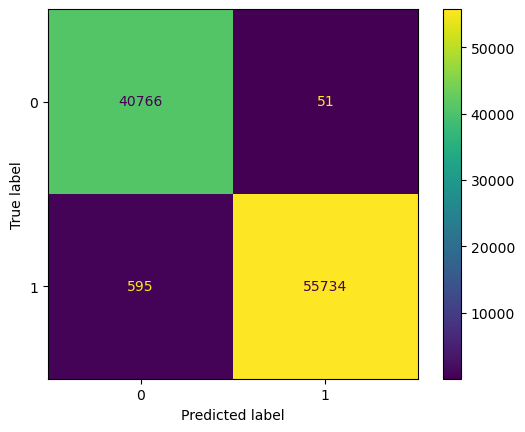

In [14]:
y_pred_test = lr.predict(x_test)
evaluate_model(y_test, y_pred_test)

##### 4. Сохранение модели логистической регрессии и векторайзера на диск

In [17]:
with open(r'D:\Chat-bot\logistic_regression_med_talker_splitter.dill', 'wb') as f:
    dill.dump(lr, f)

In [18]:
with open(r'D:\Chat-bot\logistic_regression_vectorizer.dill', 'wb') as f:
    dill.dump(vectorize, f)